# Определение стоимости автомобилей

<font style='font-size:20px; font-weight:bold'>Основные сведения</font><br/>

**Цель:** 
Построить модель, которая умеет определять рыночную стоимость автомобиля.


**Примечания заказчика:**
Используйте разные модели. Сравните характеристики.

- для оценки качества моделей применяйте метрику RMSE;
- значение метрики RMSE должно быть меньше 2500;
- используйте библиотеку LightGBM и её средствами постройте модели градиентного бустинга;
- оцените время выполнения ячейки кода Jupyter Notebook, где обучаются модели;


<font style='font-size:20px; font-weight:bold'>Этапы работы</font><br/>

1. Загрузка данных.
2. Изучение данных и подготовка.
3. Подготовление выборок для обучения моделей.
4. Обучение разных моделей.
5. Оценка времени обучения, времени предсказания и качества моделей.
6. Выбор лучшей модели.



<font style='font-size:20px; font-weight:bold'>Описание данных</font><br/>

Данные находятся в файле autos.csv


**Даны исторические данные автомобилей:**

- технические характеристики;
- комплектации;
- цены.


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)





## Подготовка данных

### Первичная загрузка

Произведём импорт основных библиотек и модулей

In [1]:
!pip install lightgbm

In [2]:
!pip install phik

In [3]:
import time
import math
from IPython.display import display

import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

Определим функцию для загрузки файла

In [4]:
def download_file(name):
    """
    Функция проходит по возможным директориям 
    в попытке найти файл, используя конструкции
    try, except и итераторы. Возвращая прочтённый 
    файл или ошибку, если файл не найден.
    """
    def read(name):
        next_step = next(step)
        print(f'Пробую найти файл в {next_step}: {directory[next_step]}.')
        return pd.read_csv(directory[next_step] + name + '.csv')
    
    def error(err):
        print(f'Возникла ошибка: {err}\n')
        
    directory = {'windows':'', 'linux':'/datasets/', 'Internet':'https://..'}
    step = iter(directory)
    
    try:
        data = read(name)
    except FileNotFoundError as err:
        error(err)
        try:
            data = read(name)
        except FileNotFoundError as err:
            error(err)
            try:
                data = read(name)
            except FileNotFoundError:
                return error(err)
            
    print('Успех!')            
    return data           

Получим файл

In [5]:
data = download_file('autos')
data_shape_zero_initially = data.shape[0]

Пробую найти файл в windows: .
Успех!


### Изучение структуры файла

Чтение файла методом `head`

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Оценка методом `describe`

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


*Некоторые имена столбцов состоят из нескольких слов, разделение идёт по символам верхнего регистра. Заметно наличие пропусков в данных. Некоторые признаки, предположительно не носят информативный характер и их стоит удалить:* **DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen , RegistrationMonth.** 

Заметно наличие выбросов, некоторые значения сразу говорят об ошибках в столбцах: **Price, RegistrationYear, Power, RegistrationMonth.**

Получение представления о данных методом `info`

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

1. Столбцы по типу данных, практически соответствуют себе. Возможно, стоит для столбцов с датой использовать datetime.
2. Обнаружены пропуски в признаках. 

Выделим столбцы, где обнаружены пропуски и сделаем предположение о характере пропусков.

In [9]:
def how_percent(count, signs=2):
    return round(count/data.shape[0] *100,signs)

def isna_info(data):
    isna_info = data.isna().sum().sort_values(ascending=False)
    count = isna_info.loc[isna_info > 0]
    percent = how_percent(count)
    return pd.DataFrame({'количество':count, '%':percent})

isna_info(data)

,количество,%
Repaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56


- repaired — наличие пропусков вызвано, скорее всего, отсутствие машины в ремонте, вероятно, это новый автомобиль или автомбиль, который долгое время не использовался, также не стоит исключать вероятность пропуска в данных в результате ошибки; 
- vehicle_type, fuel_type, gearbox, model — вероятно, вызван ошибкой в данных или не возможностью заполняющего корректно указать значение.


### Первичная предобработка

#### Корректрировка имён столбцов

Обнаруженные недочёты в именах столбцов устраним. Определим функцию для переименования столбцов.

In [10]:
def renaming_columns(data):
    """Функция меняет имена столбцов, 
    переводит в нижний регистр имена и 
    разделяет нижним подчёркиванием слова.
    """
    columns = []
    for el in data.columns:
        word = ''
        for i in range(len(el)):
            if el[i].islower():
                word += el[i]
            elif el[i].isupper() and i > 0:
                word += '_' + el[i].lower()
            else: 
                word += el[i].lower()
        columns.append(word)
    print(f'after update: {columns}')    
    return columns

In [11]:
data.columns = renaming_columns(data)

after update: ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


#### Корректировка типов данных

Определим функцию для корректировки столбцов в которых имеется отношение к дате и времени.

In [12]:
def type_date(data):
    dates = ['date_crawled', 'date_created', 'last_seen']
    for el in dates:
        data[el] = pd.to_datetime(data[el], format='%Y-%m-%d %H:%M:%S')
        
    return data

In [13]:
data = type_date(data)

#### Оценка и удаление столбцов

Решим вопрос про удаление выявленных ранее, потенциально не нужных столбцов: DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen, RegistrationMonth.

In [14]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


*Столбцы number_of_pictures и postal_code не несут значимой информации, их можно удалить. Эти данные скорее могут увеличить популярность объявления, чем его стоимость.*

Столбцы, которые несут информацию о времени размещения объявления, последнем входе пользователя и дате скачивания не несут прямой информации о стоимости. Характер этих столбцов может косвенно влиять на неё, например, если дата размещения объявления очень старая и она уже не соответствует курсу. Оценим целесообразность удаления этих столбцов.

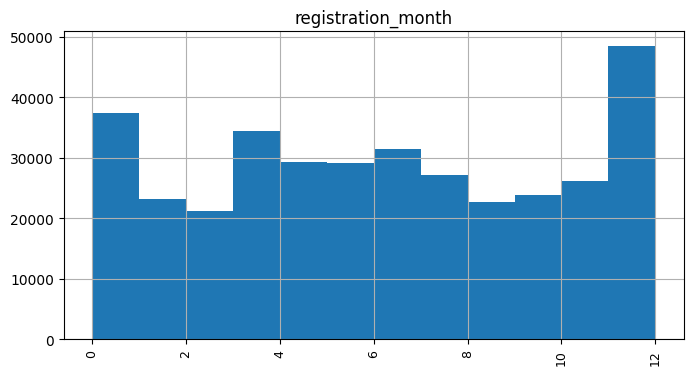

In [15]:
data.hist('registration_month', bins = 12, figsize=(8,4), xrot=90, xlabelsize=9);

In [16]:
how_percent(data.loc[data['registration_month'] == 0].shape[0])

10.54

*Месяц регистрации представленный 0, скорее всего обозначает пропуск в данных. Остальные данные представлены нормально, где наиболее популярным месяцем регистрации авто является декабрь. Данные в этом столбце не сказываются на стоимость.*

Оценим, когда анкеты были созданы

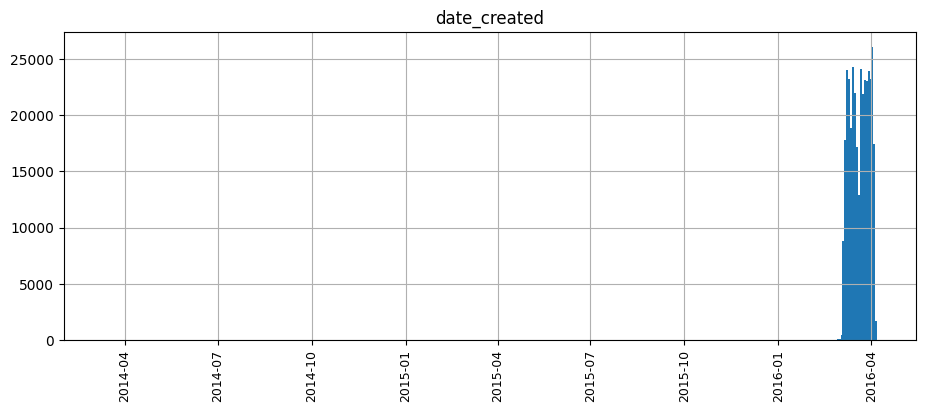

In [17]:
data.hist('date_created', bins = 400, figsize=(11,4), xrot=90, xlabelsize=9);

In [18]:
date_created_values = data['date_created'].sort_values().value_counts()
date_created_values.tail()

2015-11-10    1
2016-01-06    1
2015-03-20    1
2015-06-18    1
2015-11-12    1
Name: date_created, dtype: int64

In [19]:
print(date_created_values.loc[date_created_values < 2].count())

20


*Достаточно большое количество объявлений представлено в одном промежутке времени, однако, существует множество одиноких объявлений, созданных, вероятно в самом начале организации сервиса по продажам.*

Оценим, когда была последняя активность

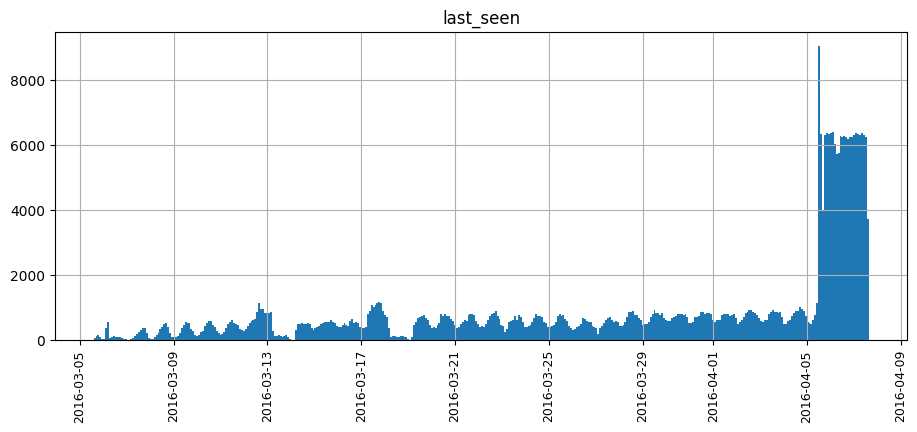

In [20]:
data.hist('last_seen', bins = 400, figsize=(11,4), xrot=90, xlabelsize=9);

Оценим, когда объявление было скачано

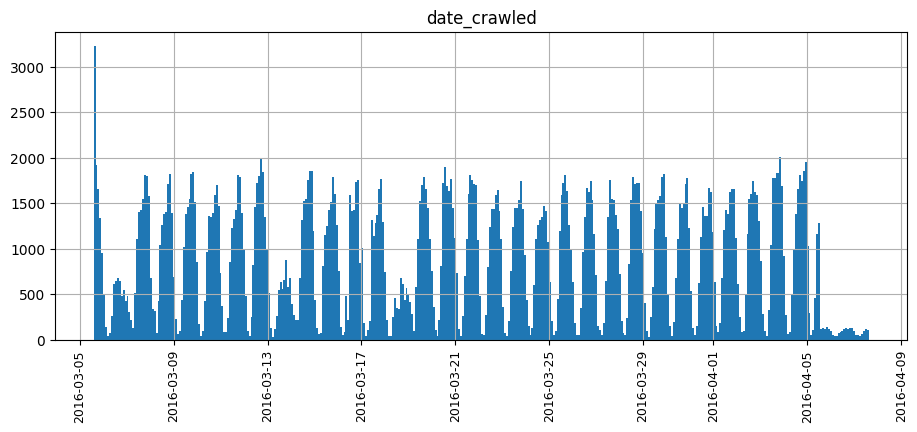

In [21]:
data.hist('date_crawled', bins = 400, figsize=(11,4), xrot=90, xlabelsize=9);

Сопоставим три таблицы

In [22]:
data.loc[:, ['date_crawled', 'date_created', 'last_seen']].sort_values(by='date_created').head(10)

,date_crawled,date_created,last_seen
61207,2016-03-16 11:48:06,2014-03-10,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,2015-03-20,2016-04-07 03:45:01
342275,2016-03-05 21:44:26,2015-06-18,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,2015-08-07,2016-04-07 09:15:23
175103,2016-03-08 17:57:45,2015-08-10,2016-04-05 20:46:54
221002,2016-03-15 01:56:49,2015-09-04,2016-03-15 15:49:29
75598,2016-03-14 08:43:53,2015-09-04,2016-03-15 14:16:58
340616,2016-03-05 21:51:02,2015-09-09,2016-04-05 17:46:04
9972,2016-03-05 17:53:53,2015-11-02,2016-03-17 15:46:57
161567,2016-03-05 14:31:01,2015-11-08,2016-04-06 23:15:36


*Из гистограмм видно, что дата скачивания объявления не всегда соответствует его актуальности. Для корректного обучения модели, лучше всего выбрать промежуток, где за определённый момент времени цены на авто формируются наиболее большим набором данных. Из этого следует что будет не лишним ограничить выборку по дате создания анкеты.*

Определим промежуток времени

In [23]:
data['date_created'].describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-20 19:12:07.753274112
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

In [24]:
data_border = data['date_created'].value_counts()
data_border = data_border.reset_index().sort_values(by='index', ascending = False)
data_border.head(40)[30:]

,index,date_created
13,2016-03-08,11854
8,2016-03-07,12244
29,2016-03-06,5505
27,2016-03-05,8186
33,2016-03-04,601
35,2016-03-03,396
39,2016-03-02,37
36,2016-03-01,50
38,2016-02-29,46
37,2016-02-28,49


In [25]:
how_percent(data_border.loc[data_border['index'] >= '2016-03-05', 'date_created'].sum()) 

99.55

*Определим границу датой 2016-03-05, отсекая меньше 1% данных.*

In [26]:
data = data.loc[data['date_created'] >= '2016-03-05']

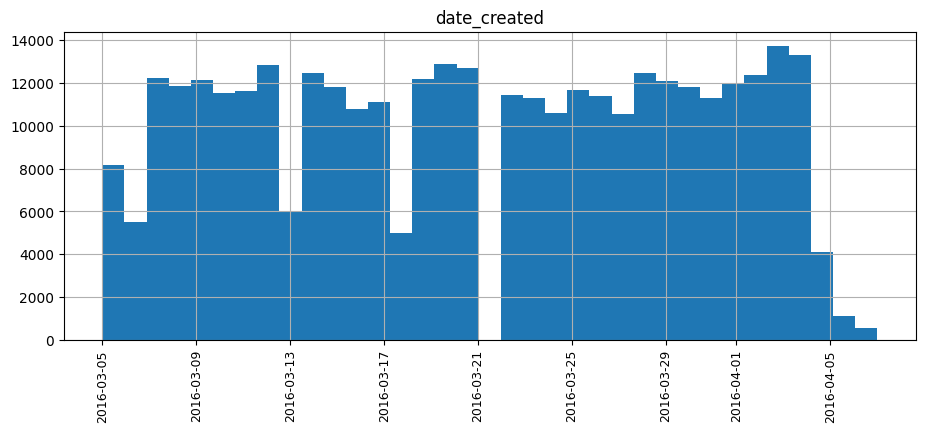

In [27]:
data.hist('date_created', bins = 35, figsize=(11,4), xrot=90, xlabelsize=9);

*Получив удовлетворительный результат, избавимся от столбцов, которые нам больше не нужны.*

Определим функцию, произведём удаление

In [28]:
def del_poor_cool(data):
    poor_col = ['date_crawled', 'date_created', 'last_seen',
                'number_of_pictures', 'postal_code', 'registration_month']
    data = data.drop(poor_col, axis=1)
    return data

In [29]:
data = del_poor_cool(data)

### Оценка значений

Определим функцию для получения численного и процентного количества

In [30]:
def values_with_percent(column):
    ans = data[column].value_counts(dropna=False)
    ans1 = how_percent(data[column].value_counts(dropna=False))
    return pd.concat({column:ans, '(%)':ans1}, axis=1)

Проведёи исследование данных, значений столбцов, их связей, дубликатов.

In [31]:
data.describe()

,price,registration_year,power,kilometer
count,352792.000000,352792.000000,352792.000000,352792.000000
mean,4412.256451,2004.238772,110.071793,128230.033561
std,4512.839543,90.412328,190.213601,37895.028368
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6399.000000,2008.000000,142.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [32]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### price

Оценим значения столбца

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

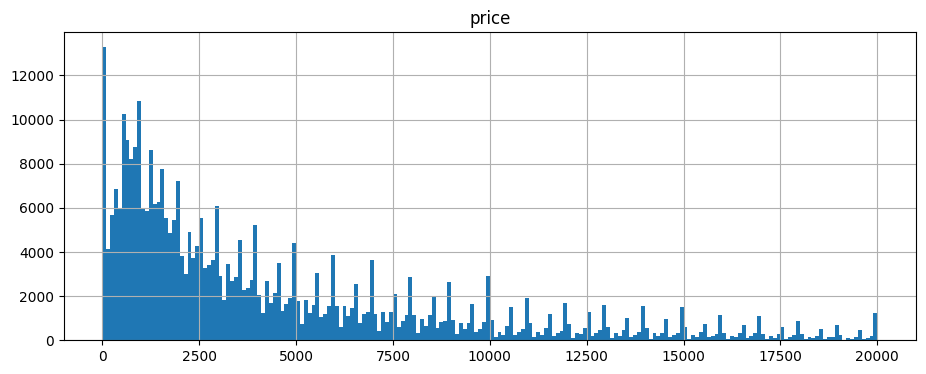

In [33]:
data.hist('price', bins = 200, figsize=(11,4))

In [34]:
data['price'].describe()

count    352792.000000
mean       4412.256451
std        4512.839543
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6399.000000
max       20000.000000
Name: price, dtype: float64

<AxesSubplot:>

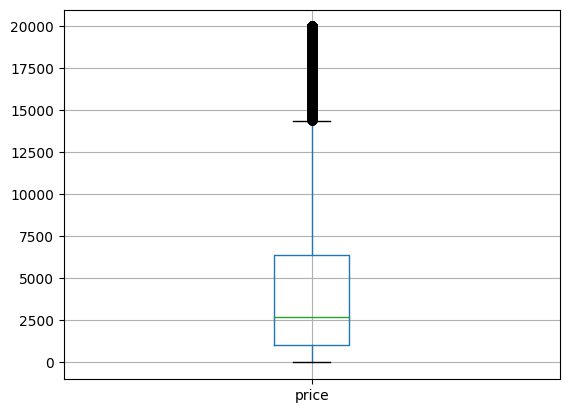

In [35]:
data.boxplot('price')

In [36]:
data['price'].value_counts().reset_index().sort_values(by='index').head(5)

,index,price
0,0,10747
75,1,1187
969,2,12
1111,3,8
3039,4,1


In [37]:
how_percent(data.loc[data['price'] == 0].shape[0]) 

3.05

*Гистограмма показывает очень интересное распределение цен на авто. Подозрительно, что около 3% данных равны 0. Предположительно, это могут быть уже проданные авто. Либо, таким образом могут быть обозначены дубликаты. Значения, где цены равны от 1 евро и выше вызывают подозрения, согласно курсу ЦБ, 1 евро летом 2016 года составляло примерно 70 рублей. Изучив несколько сайтов были найдены автомобили за 16-20 тыс.рублей, т.е. где-то 228-250 евро. На иностарнных сайтах были найдены атво за 100$ это примерно 92 евро. А на иностранном сайте <a href="https://www.autoscout24.com/lst?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&powertype=kw&search_id=1pa16z2wqyn&sort=price&ustate=N%2CU">www.autoscout24.com</a> были найдены авто с ценой 1 евро. Предположительно, заказчик ориентирован на торговлю за рубежом, исходя из того в какой валюте представлен транспорт(а значит, что стоимость в 1 евро уместа, согластно сайту). Однако, исходя из требований заказчика, приложение должно определять рыночную стоимость автомобиля. Соответственно, необходимо для модели машинного обучения подготовить данные ориентированные на клиента, который заинтересован продать своё авто как можно выгоднее для себя. Цены, которые представлены нижними значениями, предположительно, оценивают автомобили, почти не пригодные для эксплуатации. Также вероятно, что владельцы этих автомобилей нацелены просто на передачу авто за символическую сумму по иным причинам(особенности менталитета, дорогая аренда места хранения не используемого авто и т.д.). В итоге ограничимся наиболее приемлимыми ценами на авто, изуим нижнии границы цен.*

<AxesSubplot:>

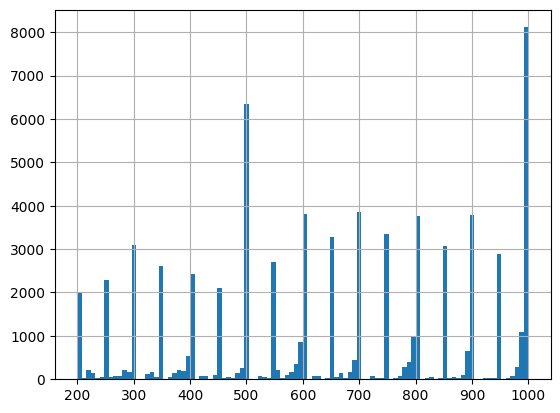

In [38]:
data['price'].hist(bins=100, range=(200,1000))

Для более корректной фильтрации оценим, есть ли связь между 'kilometer' и 'price'. Есть предположение, что авто с малым пробегом стоят больше.

In [39]:
data['kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

<AxesSubplot:>

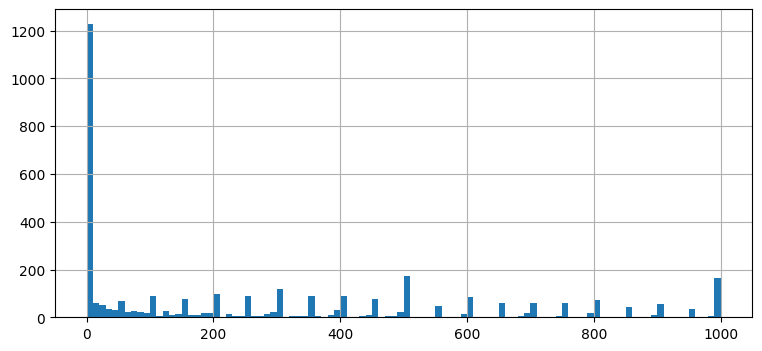

In [40]:
data.loc[data['kilometer'] == 5000, 'price'].sort_values().hist(bins=100, range=(0,1000), figsize=(9, 4))

Изучим связть между 'repaired' и 'price'

In [41]:
data.loc[(data['price'] >= 2) & (data['price'] <= 800), 'repaired'].value_counts(dropna=False)

no     21255
NaN    19481
yes    14592
Name: repaired, dtype: int64

*Связи между столбцами не заметны. Исходя из изложенных предположений и цен, ограничемся стоимостью автомобиля в 99 евро, что составляет примерно 9 057 рублей.*

In [42]:
data.loc[data['price'] <= 99, 'price'].shape[0]/data.shape[0]*100

3.766241864894895

Изучим дубликаты в данных без ключевого столбца `price`

In [43]:
dup_price_filtr = data.duplicated(subset=[el for el in data.columns if el != 'price'], keep=False)
data.loc[(dup_price_filtr)].sort_values(by=[el for el in data.columns if el != 'price'], ascending=True).head(6)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
168707,3000,bus,1973,NaN,0,other,150000,NaN,volkswagen,yes
269797,3000,bus,1973,NaN,0,other,150000,NaN,volkswagen,yes
51490,13500,bus,1975,manual,0,transporter,150000,petrol,volkswagen,NaN
327005,7800,bus,1975,manual,0,transporter,150000,petrol,volkswagen,NaN
37276,17950,bus,1976,manual,50,other,100000,petrol,volkswagen,no
127574,13900,bus,1976,manual,50,other,100000,petrol,volkswagen,no


In [44]:
data.loc[(dup_price_filtr)].sort_values(by=[el for el in data.columns if el != 'price'], ascending=False).head(6)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
294605,17800,wagon,2016,manual,99,other,5000,gasoline,peugeot,no
310248,17800,wagon,2016,manual,99,other,5000,gasoline,peugeot,no
14806,17500,wagon,2015,manual,150,leon,20000,petrol,seat,no
42206,18900,wagon,2015,manual,150,leon,20000,petrol,seat,no
48936,17000,wagon,2015,manual,125,superb,40000,petrol,skoda,no
297156,17000,wagon,2015,manual,125,superb,40000,petrol,skoda,no


*Заметен сильный разброс цен для авто зарегестрированных давно. У авто, зарегистрированных недавно, разброс цен гораздо меньше.*

**Вывод:**

Требуется провести фильтрацию данных, убрать значения, где присутствует 0. Это целевой признак, его парамтеры критически важны. Ограничить нижнюю границу в 99 евро, верхнюю границу трогать не будем.

#### vehicle_type

Оценим столбец на предмет корректности заполненных значений, есть вероятность, что названия могут дублировать друг друга.

In [45]:
data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Разберёмся, что эти типы значат:
1. bus — скорее всего относится к автобусам, компактвэнам, минивенам, хетчбэкам;
2. convertible — кабриоле́т; 
3. coupe — купе;
4. sedan — седан;
5. small — европейский малый класс;
6. suv — кроссовер(Sports Utility Vehicle);
7. wagon — универсал('сарай', 'вагон', 'авант', 'эстейт', 'комби').

Оценим распределение типов автомобильного кузова

In [46]:
values_with_percent('vehicle_type')

,vehicle_type,(%)
sedan,91033,25.80
small,79495,22.53
wagon,64876,18.39
NaN,37352,10.59
bus,28652,8.12
convertible,20109,5.70
coupe,16082,4.56
suv,11916,3.38
other,3277,0.93


- other — тип кузова, который определить не удасться, имея неполный данные, которые завяленно отличаются друг от друга не выйдет в конечном итоге получить качественное предсказание по этому типу. Поэтому, смысла оставлять его особо нет.

**Вывод:** необходимо избавиться от типа кузова(vehicle_type) other — его присутствие не обеспечит надлежащего качества. 

#### registration_year	

In [47]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [48]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

*Из полученного количества стоит обратить внимание только на наиболее достоверные.*

array([[<AxesSubplot:title={'center':'registration_year'}>]], dtype=object)

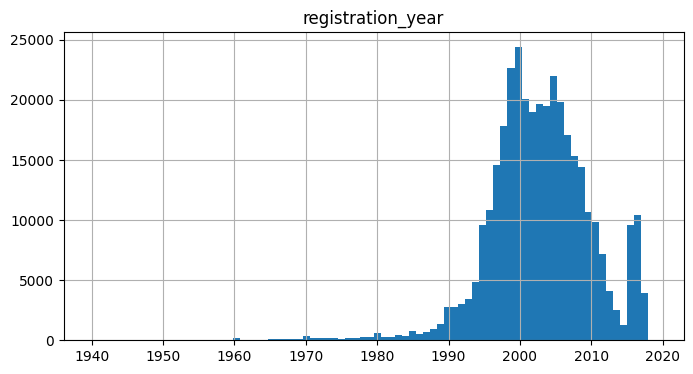

In [49]:
data.loc[(data['registration_year'] >= 1940) & (data['registration_year'] <= 2030)]\
.hist('registration_year', bins = 80, figsize=(8,4))

*С левого конца были отсечены значения вплоть до 1940 года, хотя и их стоит убрать. Вводить ограничения будем в соответствии с началом роста количества авто с годом регистрации от 1980-1990. Значения старше 2016 года не могут быть верными, так как они не соответствуют дате скачивания анкет. Есть вероятность, что возможна ошибка в данных регистрации авто или данных по анкетам.*

Оценим значения для ввода ограничений

In [50]:
data.loc[(data['registration_year'] >= 1980) &
         (data['registration_year'] <= 1990), 'registration_year']\
        .value_counts()

1990    2795
1989    1313
1988     938
1985     753
1987     666
1980     587
1986     533
1983     425
1984     396
1982     312
1981     259
Name: registration_year, dtype: int64

Узнаем сколько значений останется за бортом

In [51]:
how_percent(data.loc[(data['registration_year'] <= 1989), 'registration_year'].count())

2.73

*Будем считать 1989 год точкой старта.*

In [52]:
data.loc[(data['registration_year'] >= 2014) &
         (data['registration_year'] <= 2025), 'registration_year']\
        .value_counts()

2017    10399
2016     9573
2018     3947
2014     2521
2015     1290
2019       25
Name: registration_year, dtype: int64

In [53]:
how_percent(10399, 4)

2.9476

*Странно, что около 10000 значений приходится на 2017 год. Это порядка 3%. Допустим, что всё-таки ошибка где-то присутствует.*

Узнаем сколько значений останется за бортом

In [54]:
how_percent(data.loc[(data['registration_year'] >= 2018), 'registration_year'].count())

1.16

**Вывод:** требуется ограничить значения по году регитсрации, обнаружены явные ошибки. Для ограничения использовать диапазон 1989 - 2017. Порядка 4% данных будет отсеяно.

#### gearbox

Изучим уникальные значения

In [55]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Определим процентное соотношение

In [56]:
values_with_percent('gearbox')

,gearbox,(%)
manual,267071,75.70
auto,65946,18.69
NaN,19775,5.61


*Оставим данные как есть, тут ничего не сделаешь*

**Вывод:** не выявлено явных ошибок.

#### power

Оценим распределение значений

array([[<AxesSubplot:title={'center':'power'}>]], dtype=object)

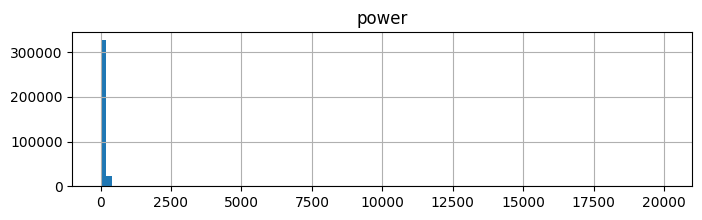

In [57]:
data.hist('power', bins = 100, figsize = (8, 2))

In [58]:
data['power'].describe()

count    352792.000000
mean        110.071793
std         190.213601
min           0.000000
25%          69.000000
50%         105.000000
75%         142.000000
max       20000.000000
Name: power, dtype: float64

In [59]:
how_percent(data.loc[(data['power'] == 0), 'power'].shape[0])

11.36

*Из графика и таблицы видно, что есть значения, которые равны 0(11%), также из основной массы выделяются значения правого диапазона значений. Предположительно, значением 0 обозначены пропуски в данных. Их можно заполнить средним по каждому бренду, модели  и типу кузова, предварительно отфильтровав выбросы самых больших значений.*

Определим границы для фильтрации больших значений. Отбросим наиболее выбивающиеся значения, попробуем их выделить.

In [60]:
np.percentile(data['power'].sort_values(), 90)

179.0

In [61]:
np.percentile(data['power'].sort_values(), 99.9)

700.4180000000633

<AxesSubplot:>

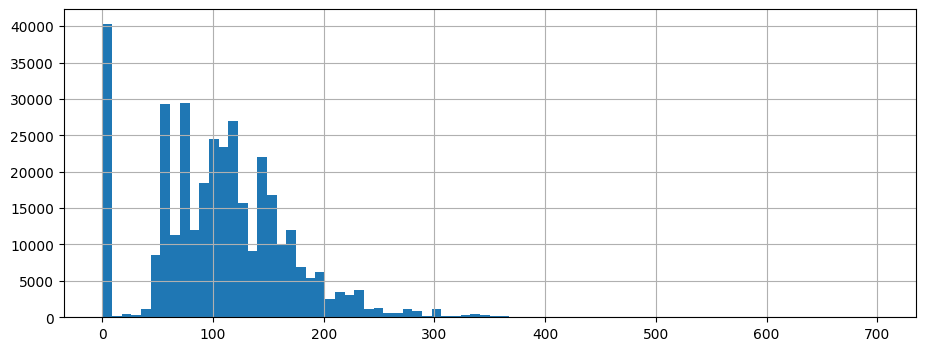

In [62]:
data.loc[(data['power'] >= 0) & (data['power'] <= 700), 'power'].hist(bins=80, figsize=(11, 4))

In [63]:
data.loc[data['power'] >= 700, 'power'].value_counts().reset_index().sort_values(by='index')[:8]

,index,power
25,700,2
160,702,1
161,703,1
172,732,1
216,743,1
7,750,4
26,751,2
237,754,1


In [64]:
how_percent(data.loc[data['power'] >= 700, 'power'].count())

0.1

*Остановимся на значении в 340 отбросив 0.1% данных. Чтобы избавиться от лишнего и не отсекать слишком много.*

Оценим нижнюю границу, исключая 0.

<AxesSubplot:>

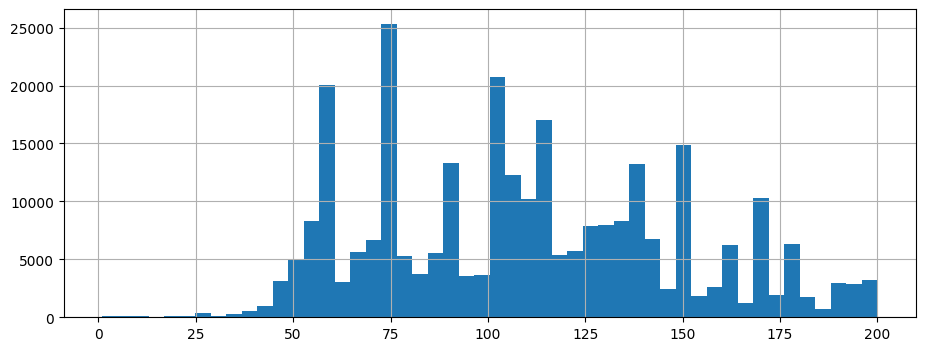

In [65]:
data.loc[(data['power'] > 0) & (data['power'] <= 200), 'power'].hist(bins=50, figsize=(11, 4))

In [66]:
data.loc[data['power'] <= 15, 'power'].value_counts().reset_index().sort_values(by='index').tail(5)

,index,power
4,11,28
5,12,22
13,13,8
6,14,20
7,15,20


*На  сайте <a href="https://auto.ru/krasnogorsk/cars/used/?power_to=13">auto.ru</a> покупки и продажи авто были найдены экземпляры с минимальной мощнсотью в 11 л.с., обозначим это нижней границей.* 

**Вывод:** требуется восстановлнение данных, где в признаке power указан 0, предварительно отфильтровав по нижнему значению в 11 л.с., а по верхнему значению в 340 л.с..

#### model

Оценим значения. Изучим наименования на предмет не корректного заполнения.

In [67]:
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Проверим, не повтрояют ли представители брендов названия моделей друг друга.


In [68]:
unique_mod = []
non_unique_mod = []
for el in data['brand'].unique():
    model = data.loc[data['brand'] == el, 'model'].unique()
    for el in model:
        if el not in unique_mod:
            unique_mod.append(el)
        else:
            non_unique_mod.append(el)
            
print(set(non_unique_mod))

{nan, '1_reihe', 'other', 'grand', 'freelander', '3_reihe', 'discovery', '5_reihe', 'matiz', 'defender'}


*Имеются повтроения, это надо учитывать при обработке значений.*

**Вывод:** по столбцу model не выявлено аномалий.

#### kilometer

In [69]:
data['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000], dtype=int64)

*Данные представлены очень небольшим набором значений, как если бы они перед этим проходили категоризацию. Предположительно этот столбец не дожен оказать сильного влияния на точность модели ввиде его ограниченного набора данных и специфики показателя.*

array([[<AxesSubplot:title={'center':'kilometer'}>]], dtype=object)

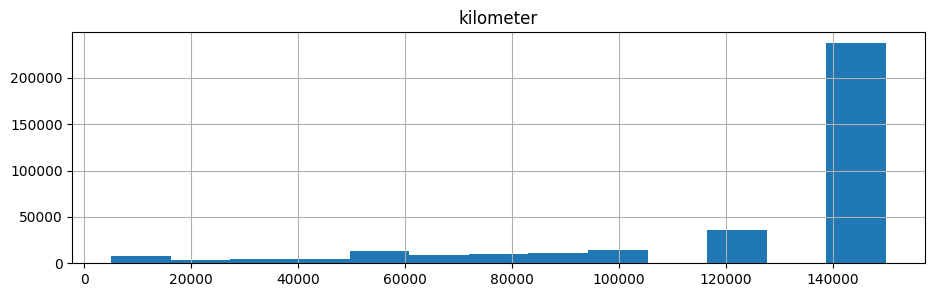

In [70]:
data.hist('kilometer', bins=13, figsize=(11,3))

In [71]:
how_percent(data['kilometer'].value_counts())

150000    67.25
125000    10.28
100000     4.19
90000      3.26
80000      2.83
70000      2.42
60000      2.10
5000       1.81
50000      1.75
40000      1.38
30000      1.25
20000      1.12
10000      0.34
Name: kilometer, dtype: float64

*Данные не имеют пропусков, это приятно. Основной набор данных составляют подержанные авто, откатавшие большое расстояние(100-150тыс.). Малое количество данных составляют относительно новые автомобили, пройденное расстояние которых малозначительно(10-90тыс.).*

**Вывод:** *необходимость в корректировке столбца kilometer сомнительна. Данные на первый взгляд нормальные. Существует предположение о малой значимости этого столбца для машинного обучения ввиду специфики значений и их ограниченности.*

#### fuel_type	

Оценим используемые типы топлива

In [72]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Наименования:
- petrol — бензин(Великобритания);
- gasoline — бензин(США);
- lpg (Liquified Petroleum Gas) – сжиженный газ (пропан-бутан);
- hybrid — гибридное топливо(для машин, которые могут работать и от горючего и от электричества);
- cng (КПГ -компримированный (сжатый) природный газ);
- electric — это синтетический, альтернативный вид топлива, производимого с помощью электроэнергии.
- other — интересно, что же имеется ввиду.

*Обнаружено два одинаковых вида топлива: petrol и gasoline.*

Изучим распределение значений

In [73]:
values_with_percent('fuel_type')

,fuel_type,(%)
petrol,215402,61.06
gasoline,98245,27.85
NaN,32778,9.29
lpg,5276,1.50
cng,565,0.16
hybrid,233,0.07
other,204,0.06
electric,89,0.03


**Вывод:** *Тип other может быть пропуском, либо, это действительно, какой-то особый вид топлива. Интересно, что около 0.3% данных составляют редкие виды топлива(cng, hybrid, other, electric), предположительно, эти объекты обладают малым количеством значений, что негативно скажется на обучении модели. Возможно, после попытки восстановления, стоит еще раз оценить значения на предмет удаления. 9.28% — это пропущенные значения. Стоит скорректировать значения petrol и gasoline это одно и тоже.*

#### brand

Изучим наименования брендов на предмет повторений и корректности наименований.

In [74]:
data['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

*Наименования значений представлены нормально.*

Изучим распределение авто по брендам

In [75]:
values_with_percent('brand')

,brand,(%)
volkswagen,76693,21.74
opel,39753,11.27
bmw,36739,10.41
mercedes_benz,31905,9.04
audi,29326,8.31
ford,25074,7.11
renault,17860,5.06
peugeot,10951,3.10
fiat,9597,2.72
seat,6869,1.95


**Вывод:** *исходя из полученных значений можно сделать предположение о том, что готовая модель машинного обучения будет лучше предсказывть цену авто для брендов, которые представлены большим количеством значений. В целом значения представлены нормально, столбец в корректировке не нуждается.*

#### repaired

Оценим столбец по уникальности и процентному соотношению

In [76]:
values_with_percent('repaired')

,repaired,(%)
no,245955,69.72
NaN,70899,20.10
yes,35938,10.19


*Достаточно большое количество пропусков, предположительно не ставился пользователем ввиду отсутствия машины в ремонте. Этот столбец, после восстановления данных можно кодировать в 0 и 1.*

#### Оценка дубликатов

Посмотрим на общее количество явных дубликатов.

In [77]:
dup_price_filtr = data.duplicated()
data.loc[(dup_price_filtr)].sort_values(by=[el for el in data.columns], ascending=True).head(6)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
283241,0,bus,1994,manual,0,transporter,150000,gasoline,volkswagen,NaN
254668,0,bus,1994,manual,68,transporter,150000,gasoline,volkswagen,NaN
74809,0,bus,1995,manual,68,transporter,150000,gasoline,volkswagen,no
300163,0,bus,1995,manual,68,transporter,150000,gasoline,volkswagen,no
259813,0,bus,1995,manual,102,transporter,150000,gasoline,volkswagen,no
64344,0,bus,1996,auto,110,transporter,150000,petrol,volkswagen,no


In [78]:
how_percent(data.duplicated().value_counts()[1])

12.68

*Выявили почти 13% дубликатов во всей выборке.*

**Вывод:** *данные имеют 13% дубликатов, возможно, что после корректировки информации по столбцам количество дубликатов изменится. Стоит провести повторный анализ после мероприятий предобработки для принятия решения о корректировке.*

#### Корреляция значений

In [79]:
data.corr()

,price,registration_year,power,kilometer
price,1.000000,0.026901,0.158602,-0.333130
registration_year,0.026901,1.000000,-0.000829,-0.053605
power,0.158602,-0.000829,1.000000,0.023871
kilometer,-0.333130,-0.053605,0.023871,1.000000


*Обычный способ выявления коррелирующих значений не дал существенных результатов, воспользууемся библиотекой `phik`.*

Попробуем восстановить утраченные значения, чтобы понять какие признаки могут дополнять друг друга, попробуем найти корреляцию используя библиотеку `phik`.

In [80]:
def phik_corr_matrix(data):
    interval_cols = ['price', 'power', 'kilometer']
    return data.phik_matrix(interval_cols=interval_cols)

Определим функцию для упрощения читаемости таблицы.

In [81]:
def most_corr_val_phik(phik_corr, cor_cof=.4):
    """ Функция выводит имя столбца и список,
    который содержит имя признака с 
    которым коррелирует столбец и значение корреляции
    в соответствии с условием cor_cof
    
    """
    data_corr_phik = []
    # Блок выбирает значение, имя столбца, имя строки,
    # которые превышают указанный cor_cof и сохраняет в
    # data_corr_phik
    for el in phik_corr:
        for i in range(len(phik_corr[el])):
            if phik_corr[el][i] > cor_cof and phik_corr[el][i] != 1:
                data_corr_phik.extend([[el, phik_corr.index[i], round(phik_corr[el][i],3)]])

    # Этот блок фильтрует 
    # и сортирует значения
    some_dict = {}
    for el in data_corr_phik:
        for i in range(len(el)-1):
            # копирование листа
            el1 = el.copy()
            el1.remove(el[i])
            # внесение и создание ключа со значениями
            if el[i] not in some_dict.keys():
                some_dict[el[i]] = [el1]
            else:
                # Проверка на наличие однотипных значений
                count = 0
                for tr in some_dict[el[i]]:
                    if tr == el1:
                        count += 1
                if count == 0:
                    some_dict[el[i]] += [el1]
    count = 0
    for key, values in some_dict.items():
        count += 1
        print(f'{count}. {key:<15} {values}\n')
        

In [82]:
phik_corr = phik_corr_matrix(data)
phik_corr

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.268142,0.674610,0.323692,0.005771,0.579035,0.310958,0.257507,0.355571,0.380445
vehicle_type,0.268142,1.000000,0.278259,0.289090,0.011784,0.917284,0.172040,0.330037,0.633306,0.084591
registration_year,0.674610,0.278259,1.000000,0.142468,0.090179,0.665489,0.655332,0.392530,0.424113,0.223959
gearbox,0.323692,0.289090,0.142468,1.000000,0.010526,0.647004,0.016211,0.151410,0.520612,0.043643
power,0.005771,0.011784,0.090179,0.010526,1.000000,0.000000,0.000000,0.010865,0.004528,0.011686
model,0.579035,0.917284,0.665489,0.647004,0.000000,1.000000,0.443230,0.555037,0.998373,0.159662
kilometer,0.310958,0.172040,0.655332,0.016211,0.000000,0.443230,1.000000,0.148282,0.274939,0.113004
fuel_type,0.257507,0.330037,0.392530,0.151410,0.010865,0.555037,0.148282,1.000000,0.322657,0.044536
brand,0.355571,0.633306,0.424113,0.520612,0.004528,0.998373,0.274939,0.322657,1.000000,0.106007
repaired,0.380445,0.084591,0.223959,0.043643,0.011686,0.159662,0.113004,0.044536,0.106007,1.000000


In [83]:
most_corr_val_phik(phik_corr, .3)

1. price           [['registration_year', 0.675], ['gearbox', 0.324], ['model', 0.579], ['kilometer', 0.311], ['brand', 0.356], ['repaired', 0.38]]

2. registration_year [['price', 0.675], ['model', 0.665], ['kilometer', 0.655], ['fuel_type', 0.393], ['brand', 0.424]]

3. gearbox         [['price', 0.324], ['model', 0.647], ['brand', 0.521]]

4. model           [['price', 0.579], ['vehicle_type', 0.917], ['registration_year', 0.665], ['gearbox', 0.647], ['kilometer', 0.443], ['fuel_type', 0.555], ['brand', 0.998]]

5. kilometer       [['price', 0.311], ['registration_year', 0.655], ['model', 0.443]]

6. brand           [['price', 0.356], ['vehicle_type', 0.633], ['registration_year', 0.424], ['gearbox', 0.521], ['model', 0.998], ['fuel_type', 0.323]]

7. repaired        [['price', 0.38]]

8. vehicle_type    [['model', 0.917], ['fuel_type', 0.33], ['brand', 0.633]]

9. fuel_type       [['vehicle_type', 0.33], ['registration_year', 0.393], ['model', 0.555], ['brand', 0.323]]



Для столбцов с пропусками выявлены наиболее коррелирующие стобцы:
- vehicle_type — model(0.917), brand(0.633);
- fuel_type — model(0.555);
- gearbox — model(0.647), brand(0.521);
- model — vehicle_type(0.917), brand(0.998)
- repaired — price(0.38).

*Возможно, что используя эти столбцы удастся восстановить пропущенные значения.*

#### Заключение

По результату оценки каждого столбца были приняты заключения:

1. **price** — требуется провести фильтрацию данных, убрать значения, где присутствует 0(3%). Это целевой признак, его парамтеры критически важны. Нижнюю границу обозначить в 99 евро;
2. **vehicle_type** — необходимо избавиться от типа кузова(vehicle_type) other(0.93%) — его присутствие не обеспечит надлежащего качества;
3. **registration_year** — требуется ограничить значения по году регитсрации, обнаружены явные ошибки. Для ограничения использовать диапазон 1989 - 2017. Порядка 4% данных будет отсеяно;
4. **gearbox** — значения в порядке;
5. **power** — требуется восстановлнение данных, где в признаке power указан 0, предварительно отфильтровав по верхнему значению в 340 и нижнему в 11 л.с.;
6. **model** — по столбцу не выявлено аномалий, в наборе данных пристутсвуют одинаковые модели у разных брендов;
7. **kilometer** — необходимость в корректировке столбца kilometer сомнительна. Данные на первый взгляд нормальные. Существует предположение о малой значимости этого столбца для машинного обучения ввиду специфики значений и их ограниченности;
8. **fuel_type** — Тип other может быть пропуском, либо, это действительно, какой-то особый вид топлива. Интересно, что около 0.3% данных составляют редкие виды топлива(cng, hybrid, other, electric), предположительно, эти объекты обладают малым количеством значений, что негативно скажется на обучении модели. Возможно, после попытки восстановления, стоит еще раз оценить значения на предмет удаления. 9.28% — это пропущенные значения. Стоит скорректировать значения petrol и gasoline это одно и тоже;
9. **brand** — корректировка не нужна;
10. **repaired** — Достаточно большое количество пропусков, предположительно не ставился пользователем ввиду отсутствия машины в ремонте. Этот столбец, после восстановления данных можно кодировать в 0 и 1;
11. **оценка дубликатов** — данные имеют 13% дубликатов, возможно, что после корректировки информации по столбцам количество дубликатов изменится. Стоит провести повторный анализ после мероприятий предобработки для принятия решения о корректировке;
12. **корреляция значений** — выявлена коррелирующие столбцы с помощью которых, возможно, удастся восстановить недостающие значения: 
    - vehicle_type — model(0.917), brand(0.633);
    - fuel_type — model(0.555);
    - gearbox — model(0.647), brand(0.521);
    - model — vehicle_type(0.917), brand(0.998)
    - repaired — price(0.38).

### Корректировка значений

Этот пункт подразумевает корректировку данных для конкретных стобцов, подготоавливая набор данных для восстановления. Столбцы, которые будут рассмотрены:
- price;
- vehicle_type;
- registration_year;
- fuel_type;
- power.

Определим функцию для оценки, сколько значений осталось после удаления

In [84]:
def how_much_is_left(left=True):
    ans = round(data.shape[0]\
         /data_shape_zero_initially*100, 3)
    if left:
        print(f'Данных удалено: {100 - ans :.3f}%')
    else:    
        print(f'После удаления осталось данных:')
        print(f'- {ans}%.')

#### price

Произведём ограничение значений по цене в 99 евро.

In [85]:
data = data.loc[data['price'] >= 99]

In [86]:
how_much_is_left()

Данных удалено: 4.164%


#### vehicle_type

Избавимся от типа кузова 'other'

In [87]:
data = data.loc[data['vehicle_type'] != 'other']

In [88]:
how_much_is_left()

Данных удалено: 5.021%


#### registration_year

Введём ограничения по году регистрации автомобиля(1989 - 2017).

In [89]:
data = data.loc[(data['registration_year'] >= 1989) &
         (data['registration_year'] <= 2016)]

In [90]:
how_much_is_left()

Данных удалено: 10.900%


#### fuel_type

Cкорректируем значения petrol и gasoline это одно и тоже.

In [91]:
data.loc[data['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

Произведём фильтрацию по редким видам топлива: cng, hybrid, other, electric. 

In [92]:
data = data.loc[(data['fuel_type'] != 'cng') &
                (data['fuel_type'] != 'hybrid') &
                (data['fuel_type'] != 'other') &
                (data['fuel_type'] != 'electric')]

In [93]:
how_much_is_left()

Данных удалено: 11.152%


#### power

In [94]:
data = data.loc[(data['power'] == 0) | (data['power'] >= 11) & (data['power'] <= 700)]

In [95]:
how_much_is_left()

Данных удалено: 11.271%


#### Заключение

In [96]:
how_much_is_left(False)

После удаления осталось данных:
- 88.729%.


*В результате корректировки, набор данных лишился 8% неявной информации.*

Произведена фильтрация значений, можно приступать к восстановлению данных.

### Восстановление данных

Операцию будем проводить для столбцов в которых обнаружены пропуски:
- repaired;
- vehicle_type;
- fuel_type;
- gearbox;
- model;
- power.

Напомним корреляцию: 

- vehicle_type — model(0.917), brand(0.633);
- fuel_type — model(0.555);
- gearbox — model(0.647), brand(0.521);
- model — vehicle_type(0.917), brand(0.998)
- repaired — price(0.38).

Выовем функцию для демонстрации их количества и процентного соотношения

In [97]:
isna_info(data)

,количество,%
repaired,55008,17.49
fuel_type,21661,6.89
vehicle_type,18140,5.77
gearbox,13450,4.28
model,13390,4.26


In [98]:
values_with_percent('power')[:1]

,power,(%)
0,29331,9.33


*Начнём восстановление со столбца power*

#### power

Определим функцию для восстановления данных. Функция будет считать среднюю мощность у конкретного бренда и модели определённого типа кузова, передавая среднее значение пропускам по этому фильтру.

In [99]:
data.loc[data['power']==0, 'power'] = None

In [100]:
data['power'] = data['power'].fillna(data.groupby(by=['brand', 'vehicle_type', 'model'],\
                                                  dropna=False)['power'].transform('median'))

Оценим результат

In [101]:
data['power'].isna().value_counts()

False    314270
True        158
Name: power, dtype: int64

*Как видно, часть значений притерпело изменения, будем надеятся корректно.*

#### gearbox

Определим функцию для нахождения пропусков в `gearbox`

In [102]:
def recovery_data(column):
    new_data = data.copy()
    new_data[column] = new_data[column].fillna(new_data.groupby(by=['brand', 'vehicle_type', 'model'], dropna=False)              
                           [column].agg(lambda x: x.value_counts(dropna=False).index[0])[0])
    
    return new_data[column]

In [103]:
data['gearbox'] = recovery_data('gearbox')

Оценим результат обработки

In [104]:
data['gearbox'].value_counts(dropna=False)

manual    254148
auto       60280
Name: gearbox, dtype: int64

#### fuel_type

Используем `recovery_data` для восстановления

In [105]:
data['fuel_type'] = recovery_data('fuel_type')

Проверим результат

In [106]:
data['fuel_type'].value_counts()

petrol    309540
lpg         4888
Name: fuel_type, dtype: int64

#### vehicle_type

Основываясь на значениях корреляции, восполним столбец самым частым значением для бренда и модели. Возьмём для оценки справделивости суждения произвольный бренд и модель. 

In [107]:
data.loc[(data['brand']=='volkswagen') &
         (data['model']=='passat'), 'vehicle_type'].value_counts()

wagon          6862
sedan          2038
coupe           176
small             6
bus               5
suv               4
convertible       1
Name: vehicle_type, dtype: int64

*Если предположить, что тип кузова не указан, как раз потому, что это он наиболее распространен, тогда картинка складывается.*

In [108]:
def recovery_other_data(column):
    new_data = data.copy()
    new_data[column] = new_data[column].fillna(new_data.groupby(by=['brand', 'model'], dropna=False)\
                [column].agg(lambda x: x.value_counts(dropna=False).index[0])[0])
    
    return new_data[column]

In [109]:
data['vehicle_type'] = recovery_other_data('vehicle_type')

In [110]:
isna_info(data)

,количество,%
repaired,55008,17.49
model,13390,4.26
power,158,0.05


#### model

Этот столбец коррелирует с `vehical_type` и `brand`. Определим похожий алгоритм, как и у других столбцов. Оценим возможность заполнения модели бренда выбранным видом кузова

In [111]:
data.loc[(data['brand']=='volkswagen') &
         (data['vehicle_type']=='small'), 'model'].value_counts().head()

polo      10664
golf       5533
lupo       2351
fox         679
passat      319
Name: model, dtype: int64

*Предположительно, результат преобразования должен оправдать себя.*

In [112]:
data['model'] = data['model'].fillna(data.groupby(by=['brand', 'vehicle_type'], dropna=False)\
                ['model'].agg(lambda x: x.value_counts(dropna=False).index[0])[0])

In [113]:
isna_info(data)

,количество,%
repaired,55008,17.49
power,158,0.05


#### repaired


Основное предположение заключается в том, что автомобиль бывший в ремонте дешевле своих собратьев(коррелирует с price 0.38). На этой основе будем создавать фильтр значений, где для пропуска, если цена автомобиля ниже медианы, то был в ремонте, если выше, то не был.

In [114]:
# Список моделей, где repaired == yes
# с вычислением медианного и максимального значения цены
price_yes = data.loc[data['repaired'] == 'yes'].groupby('model', dropna=False)['price']
price_yes_median = price_yes.median()
price_yes_max = price_yes.max()

In [115]:
# Список моделей, где repaired == no
# с вычислением медианного и максимального значения цены
price_no = data.loc[data['repaired'] == 'no'].groupby('model', dropna=False)['price']
price_no_median = price_no.median()
price_no_max = price_no.max()

In [116]:
def recovery_repaired(data):
    if type(data['repaired']) != str:
        mod = data['model']
        # Проверка, есть ли модель в списках 
        if (mod in price_yes_median.index and
            mod in price_no_median.index):
            # Если есть, то вычисляется разница,
            # между значением медианы и текущей цены объекта 
            # для списков, где был ремонт и не было
            ans_yes = abs(price_yes_median[mod] - data['price'])
            ans_no = abs(price_no_median[mod] - data['price'])
            # В зависимости от того, что больше, определяется
            # принадлежность объекта к категории
            if ans_yes < ans_no:
                return 'yes'
            else:
                return 'no'
            
        # Условия ниже на случай, если модель объекта
        # находится только в одном из списков
        elif mod in price_yes_median.index:
            if data['price'] > price_yes_max[mod]:
                return 'no'
            else:
                return 'yes'
        # для неахождения категории используется
        # 1 квантиль
        elif mod in price_no_median.index:
            q1 = (price_no_median[mod]*2*.25)
            if data['price'] < q1:
                return 'yes'
            else:
                return 'no'
    else:
        return data['repaired']

In [117]:
%%time
data['repaired'] = data.apply(recovery_repaired, axis=1)

CPU times: total: 3.53 s
Wall time: 3.54 s


In [118]:
data['repaired'].value_counts()

no     250077
yes     64351
Name: repaired, dtype: int64

*В целом значения распределились в основном в сторону критерия 'yes'(около 80% значений). Критерий 'no' получил около 20% значений.*

#### Заключение

Оценим результат восстановления данных

In [119]:
isna_info(data)

,количество,%
power,158,0.05


*Удалось восстановить большую часть значений.*


### Дубликаты и удаление

Оценим, какое количество значений от изначального набора осталось

In [120]:
how_much_is_left(left=False)

После удаления осталось данных:
- 88.729%.


#### Дубликаты

Проверим набор данных на предмет оставшихся дубликатов

In [121]:
how_percent(data.duplicated().value_counts())

False    83.09
True     16.91
dtype: float64

16% дубликатов — очень много, но от них придётся избавиться.

In [122]:
data = data.drop_duplicates()

#### Пропуски

In [123]:
data = data.dropna()

#### Заключение

Проведём оценку, какой процент данных остался от начального набора.

In [124]:
how_much_is_left(left=False)

После удаления осталось данных:
- 73.699%.


*Потеря почти 24% данных — это очень много, но, видимо такой набор, процент дубликатов, оказался слишком высок.*

### Подготовка признаков

Произведём разбиение набора данных на признаки

In [125]:
features = data.drop(['price'], axis=1)
target = data['price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = .4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size = .5, random_state=12345)

dict_signs_norm = {'обучающая':features_train, 'валидационная':features_valid, 'тестовая':features_test}
print('Процентное соотношение выборок после разделения: ')
for key, val in dict_signs_norm.items():
    print(f'{key:<24} {val.shape[0]/data.shape[0]*100 :.4f}%')

Процентное соотношение выборок после разделения: 
обучающая                59.9999%
валидационная            19.9998%
тестовая                 20.0002%


**Для RFR модели**

In [126]:
def for_rfr_model(data):
    def selection(select):
        features = select.drop(['price'], axis=1)
        target = select['price']
        return features, target
    
    new_data = pd.get_dummies(data, drop_first=True)
    train, valid, test = np.split(new_data.sample(frac=1, random_state=12345),\
                                  [int(.6*len(new_data)), int(.8*len(new_data))])
    
    dict_signs = {'обучающая':train, 'валидационная':valid, 'тестовая':test}
    print('Процентное соотношение выборок после разделения: ')
    for key, val in dict_signs.items():
        print(f'{key:<24} {val.shape[0]/data.shape[0]*100 :.4f}%')
        
    rfr_features_train, rfr_target_train = selection(train)
    rfr_features_valid, rfr_target_valid = selection(valid)
    rfr_features_test, rfr_target_test = selection(test)
    
    return rfr_features_train, rfr_target_train,\
            rfr_features_valid, rfr_target_valid,\
            rfr_features_test, rfr_target_test 

rfr_features_train, rfr_target_train,\
rfr_features_valid, rfr_target_valid,\
rfr_features_test, rfr_target_test = for_rfr_model(data) 

Процентное соотношение выборок после разделения: 
обучающая                59.9999%
валидационная            19.9998%
тестовая                 20.0002%


*Подготовили данные, произвели разбиение на разные выборки.*

### Заключение

По итогу первой части были осуществлены меры по загрузке, изучению и подготовке данных:
1. Осуществлена загрузка и оценка значений, выявлены небольшие недочёты, такие как: 
    - пропуски в данных;
    - дубликаты;
    - неправильные типы данных у некоторых столбцов;
    - потенциально неинформативные столбцы;
    - некорректные имена столбцов;
    - ошибочные значения в значениях столбцов.
    
    
2. Проведена работа по устранению неточностей, корректировке и восстановлению значений.
3. Проведена работа по подготовке значений к дальнейшему исследованию. 

## Обучение моделей

Обучим разные модели меняя гиперпараметры для получения большей точности.

### CatBoost

In [127]:
cat_features=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [128]:
%%time
best_RMSE = 5000
for depth in range(5,8):
    for ite in range(100,500,200):
        model_cb = CatBoostRegressor(iterations=ite, loss_function='RMSE',depth=depth, learning_rate=0.32)

        start_cb_fit = time.process_time()
        model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=ite)
        finish_cb_fit = time.process_time() - start_cb_fit

        start_cb_predict = time.process_time()
        predictions_valid = model_cb.predict(features_valid)
        finish_cb_predict = time.process_time() - start_cb_predict

        result = mean_squared_error(target_valid, predictions_valid)**0.5
        if result <= best_RMSE:
            cb_best_RMSE_model = model_cb
            cb_best_RMSE = result
            cb_best_iter = ite
            cb_best_depth = depth
            cb_fit = finish_cb_fit
            cb_pred = finish_cb_predict
        
print(f'\nRMSE лучшей модели: {cb_best_RMSE}\n'
      f'Количество итераций: {cb_best_iter}\n'
      f'Лучшая глубина: {cb_best_depth}\n'
      f'Время обучения: {cb_fit}\n'
      f'Время предсказания: {cb_pred}\n')        

0:	learn: 3746.6673338	total: 154ms	remaining: 15.2s
99:	learn: 1631.6553930	total: 2.95s	remaining: 0us
0:	learn: 3751.0962897	total: 40ms	remaining: 12s
299:	learn: 1539.8029208	total: 13.7s	remaining: 0us
0:	learn: 3697.0042951	total: 26.3ms	remaining: 2.6s
99:	learn: 1596.9970624	total: 3.06s	remaining: 0us
0:	learn: 3703.9816438	total: 46.4ms	remaining: 13.9s
299:	learn: 1495.3510208	total: 16.5s	remaining: 0us
0:	learn: 3650.3635751	total: 30.9ms	remaining: 3.05s
99:	learn: 1563.0526265	total: 3.63s	remaining: 0us
0:	learn: 3654.2003535	total: 76.6ms	remaining: 22.9s
299:	learn: 1451.0049859	total: 21.5s	remaining: 0us

RMSE лучшей модели: 1539.1777099046433
Количество итераций: 300
Лучшая глубина: 7
Время обучения: 73.375
Время предсказания: 0.171875

CPU times: total: 3min 27s
Wall time: 1min 3s


**Используем другие гиперпараметры**

In [129]:
%%time
best_RMSE = 5000
for depth in range(13,15):
    for ite in range(100,500,200):
        model_cb2 = CatBoostRegressor(iterations=ite, loss_function='RMSE',depth=depth,
                                  learning_rate=0.32, bootstrap_type='Bernoulli')

        start_cb_fit = time.process_time()
        model_cb2.fit(features_train, target_train, cat_features=cat_features, verbose=ite)
        finish_cb_fit = time.process_time() - start_cb_fit

        start_cb_predict = time.process_time()
        predictions_valid = model_cb2.predict(features_valid)
        finish_cb_predict = time.process_time() - start_cb_predict

        result = mean_squared_error(target_valid, predictions_valid)**0.5
        if result <= best_RMSE:
            cb2_best_model = model_cb2
            cb2_best_RMSE = result
            cb2_best_iter = ite
            cb2_best_depth = depth
            cb2_fit = finish_cb_fit
            cb2_pred = finish_cb_predict
        
print(f'\nRMSE лучшей модели: {cb2_best_RMSE}\n'
      f'Количество итераций: {cb2_best_iter}\n'
      f'Лучшая глубина: {cb2_best_depth}\n'
      f'Время обучения: {cb2_fit}\n'
      f'Время преедсказания: {cb2_pred}\n')

0:	learn: 3543.2348521	total: 134ms	remaining: 13.3s
99:	learn: 1313.8996861	total: 13.1s	remaining: 0us
0:	learn: 3539.3784294	total: 191ms	remaining: 57.1s
299:	learn: 1115.6550321	total: 53.8s	remaining: 0us
0:	learn: 3537.9856207	total: 211ms	remaining: 20.9s
99:	learn: 1272.6240137	total: 21.4s	remaining: 0us
0:	learn: 3525.0073755	total: 294ms	remaining: 1m 27s
299:	learn: 1057.4571605	total: 1m 29s	remaining: 0us

RMSE лучшей модели: 1551.5125899600837
Количество итераций: 300
Лучшая глубина: 14
Время обучения: 313.421875
Время преедсказания: 0.515625

CPU times: total: 9min 55s
Wall time: 3min


### LightGBM

In [130]:
non_numiric = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [131]:
lgbm_features_train = features_train
lgbm_features_valid = features_valid

for n in non_numiric:
    lgbm_features_train[n] = lgbm_features_train[n].astype('category')
    lgbm_features_valid[n] = lgbm_features_valid[n].astype('category')

In [132]:
train_dataset = lgb.Dataset(lgbm_features_train, target_train, feature_name=lgbm_features_train.columns.tolist(),
                            categorical_feature = non_numiric)
valid_dataset = lgb.Dataset(lgbm_features_valid, target_valid, feature_name=lgbm_features_valid.columns.tolist(),
                            categorical_feature = non_numiric)

In [133]:
%%time
start = time.process_time()
booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(valid_dataset,),
                    num_boost_round=500, verbose_eval=100)
time_result = time.process_time() - start
print(f'Время обучения: {time_result}')

D:\Anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda3\envs\practicum\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\Anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 156700, number of used features: 9
[LightGBM] [Info] Start training from score 4796.283957
[100]	valid_0's l2: 2.45015e+06
[200]	valid_0's l2: 2.38544e+06
[300]	valid_0's l2: 2.35494e+06
[400]	valid_0's l2: 2.33771e+06
[500]	valid_0's l2: 2.32834e+06
Время обучения: 5.796875
CPU times: total: 5.8 s
Wall time: 1.17 s


In [134]:
%%time
start = time.process_time()

valid_prediction = booster.predict(lgbm_features_valid)

time_result = time.process_time() - start
print(f'Время предсказания: {time_result}')

result = mean_squared_error(target_valid, valid_prediction)**0.5
print('\nRMSE', result)

Время предсказания: 1.53125

RMSE 1525.8892709081686
CPU times: total: 1.53 s
Wall time: 299 ms


**Используем другие гиперпараметры и обёртку**

In [135]:
train_dataset = lgb.Dataset(lgbm_features_train, target_train, feature_name=lgbm_features_train.columns.tolist(),
                            categorical_feature = non_numiric)
valid_dataset = lgb.Dataset(lgbm_features_valid, target_valid, feature_name=lgbm_features_valid.columns.tolist(),
                            categorical_feature = non_numiric)

In [136]:
best_lgbm_RMSE = 5000
for est in range(10, 50):
    model_lgbm = LGBMRegressor(n_estimators=est)

    start_lgbm_fit = time.process_time()
    model_lgbm.fit(lgbm_features_train, target_train)
    finish_lgbm_fit = time.process_time() - start_lgbm_fit

    start_lgbm_pred = time.process_time()
    yhat = model_lgbm.predict(lgbm_features_valid)
    finish_lgbm_pred = time.process_time() - start_lgbm_pred

    result = mean_squared_error(target_valid, yhat)**0.5
    if result <= best_lgbm_RMSE:
        best_lgbm_model = model_lgbm
        best_lgbm_RMSE = result
        best_lgbm_est = est
        lgbm_time_fit = finish_lgbm_fit
        lgbm_time_predict = finish_lgbm_pred      
    
print(f'RMSE лучшей LightGBM модели: {best_lgbm_RMSE}\n',
      f'n_estimators: {est}\n',
      f'Время обучения: {lgbm_time_fit}\n',
      f'Время предсказания: {lgbm_time_predict}\n')    

RMSE лучшей LightGBM модели: 1605.548386341825
 n_estimators: 49
 Время обучения: 1.265625
 Время предсказания: 0.234375



### RandomForestRegressor

In [137]:
%%time
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(20, 30, 2):
    for depth in range (4, 7):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        time_fit = time.process_time()
        model_rf.fit(rfr_features_train, rfr_target_train) 
        time_fit_result = time.process_time() - time_fit
        time_predictions = time.process_time()
        predictions_valid = model_rf.predict(rfr_features_valid) 
        time_predictions_result = time.process_time() - time_predictions
        result = mean_squared_error(rfr_target_valid, predictions_valid)**0.5 
        if result < best_result:
            best_model_rf = model_rf
            best_result = result
            best_est = est
            best_depth = depth
            best_time_fit = time_fit_result
            best_time_predictions = time_predictions_result

print("RMSE наилучшей модели на валидационной выборке:", best_result,
      "\nКоличество деревьев:", best_est, "\nМаксимальная глубина:", depth,
     "\nВремя обучения:", best_time_fit, "\nВремя предсказания:", best_time_predictions)

RMSE наилучшей модели на валидационной выборке: 2178.785826920743 
Количество деревьев: 20 
Максимальная глубина: 6 
Время обучения: 19.625 
Время предсказания: 0.109375
CPU times: total: 4min 44s
Wall time: 4min 48s


## Анализ моделей

### CatBoost

In [138]:
top_cb_model = cb_best_RMSE_model

- RMSE лучшей модели: 1539.1777099046433;
- Количество итераций: 300;
- Лучшая глубина: 7;
- Время обучения: 72.09375;
- Время предсказания: 0.15625.

### LightGBM

In [139]:
top_lgbm_model = best_lgbm_model

- num_boost_round: 500;
- Время обучения: 5.703125;
- Время предсказания: 1.65625;
- RMSE 1525.8892709081686.

### RandomForestRegressor

In [140]:
top_rfr_model = best_model_rf

- RMSE наилучшей модели на валидационной выборке: 2178.785826920743; 
- Количество деревьев: 20; 
- Максимальная глубина: 6;
- Время обучения: 18.046875; 
- Время предсказания: 0.09375.

### Заключение

В соотношении качества и скорости выполнения лучше всего показала себя модель LightGBM, RMSE модели которой составило 1525.889.

## Проверка качества

In [141]:
test_dataset = lgb.Dataset(lgbm_features_valid, target_valid, feature_name=lgbm_features_valid.columns.tolist(),
                            categorical_feature = non_numiric)

lgbm_features_test = features_test

for n in non_numiric:
    lgbm_features_test[n] = lgbm_features_test[n].astype('category')
    
    
valid_dataset = lgb.Dataset(lgbm_features_test, target_test, feature_name=lgbm_features_test.columns.tolist(),
                            categorical_feature = non_numiric)    


start_test_time = time.process_time()
test_prediction = booster.predict(lgbm_features_test)
finish_test_time = time.process_time() - start_test_time
print(f'Время предсказания: {finish_test_time}')

result = mean_squared_error(target_test, test_prediction)**0.5
print('\nRMSE', result)


Время предсказания: 1.625

RMSE 1539.3502930966215


Модель показала высокую точность и скорость на валидационной выборке и подтвердила свои параметры на тестовой. Условия, заданные заказчиком выполнены.

## Вывод

Проведена работа по задаче заказчика, была выполнена поставленная цель, лучшей моделью оказалась LightGBM. Достигнуты характеристики модели: 
1. тестовая выборка:
    - Время предсказания: 1.546875;
    - Оценка качества RMSE: 1539.3502930966215.
    
    
2. валидационная выборка:
    - Время обучения: 5.703125;
    - Время предсказания: 1.65625;
    - RMSE 11525.8892709081686.




В работе были выполнены этапы:
1. Осуществлена загрузка и оценка значений, выявлены небольшие недочёты, такие как: 
    - пропуски в данных;
    - дубликаты;
    - неправильные типы данных у некоторых столбцов;
    - потенциально неинформативные столбцы;
    - некорректные имена столбцов;
    - ошибочные значения в значениях столбцов.
    
    
2. проведена работа по устранению неточностей, корректировке и восстановлению значений;
3. проведена работа по подготовке значений к дальнейшему исследованию; 
4. осуществлено разделение значений на выборки;
5. проведено изучение разных моделей на подготовленных данных:
- CatBoost:
    - RMSE лучшей модели: 1539.1777099046433;
    - Количество итераций: 300;
    - Лучшая глубина: 7;
    - Время обучения: 72.09375;
    - Время предсказания: 0.15625.
- LightGBM:
    - num_boost_round: 500;
    - Время обучения: 5.703125;
    - Время предсказания: 1.65625;
    - RMSE 1525.8892709081686.
- RandomForestRegressor:
    - RMSE наилучшей модели на валидационной выборке: 2178.785826920743; 
    - Количество деревьев: 20; 
    - Максимальная глубина: 6;
    - Время обучения: 18.046875; 
    - Время предсказания: 0.09375.
    
Лучшей моделью по результату анализа стала LightGBM.    
В целом поставленную задачу можно считать выполненой. 